In [8]:
!git clone https://jadelee@github.com/hanb0i/Basic-PiNN-Model-For-Three-Layered-Collision.git


Cloning into 'Basic-PiNN-Model-For-Three-Layered-Collision'...
remote: Enumerating objects: 346, done.
remote: Counting objects: 100% (346/346), done.
remote: Compressing objects: 100% (272/272), done.
remote: Total 346 (delta 142), reused 253 (delta 53), pack-reused 0 (from 0)
Receiving objects: 100% (346/346), 8.38 MiB | 25.77 MiB/s, done.
Resolving deltas: 100% (142/142), done.


In [9]:
import os, sys
from pathlib import Path

repo_root = Path('/content/Basic-PiNN-Model-For-Three-Layered-Collision')
pinn_dir = repo_root / 'pinn-workflow'
sys.path.insert(0, str(pinn_dir))
os.chdir(pinn_dir)


In [3]:
!pwd
!ls


/content/Basic-PiNN-Model-For-Three-Layered-Collision/pinn-workflow
data.py		  model.py    pinn_config.py  __pycache__  train_colab.ipynb
fea_solution.npy  physics.py  plot.py	      README.md    train.py


In [4]:
%cd /content/Basic-PiNN-Model-For-Three-Layered-Collision
!ls


/content/Basic-PiNN-Model-For-Three-Layered-Collision
benchmark_fea.py	      diagnostics.py	pinn-workflow
compare_results.py	      fea_solution.npy	__pycache__
comparison_cross_section.png  fea-workflow	pyproject.toml
comparison_top.png	      loss_curve.png	traction_top_patch.png
cross_section.png	      loss_history.npy
diagnostic_report.md	      pinn_model.pth


In [5]:
%cd /content/Basic-PiNN-Model-For-Three-Layered-Collision/pinn-workflow
!python train.py


/content/Basic-PiNN-Model-For-Three-Layered-Collision/pinn-workflow
Using device: cuda
Starting Adam Training...
Epoch 0: Total Loss: 110903600.000000 | PDE: 11027798.000000 | BC: 0.000000 | Load: 625.329895 | Interface: 0.211217 | Time: 1.5059s
Epoch 100: Total Loss: 155692.812500 | PDE: 15490.115234 | BC: 0.000000 | Load: 0.790239 | Interface: 0.004313 | Time: 54.5744s
Epoch 200: Total Loss: 68506.375000 | PDE: 6813.243164 | BC: 0.000000 | Load: 0.373002 | Interface: 0.003547 | Time: 54.4004s
Epoch 300: Total Loss: 40237.285156 | PDE: 4002.260986 | BC: 0.000000 | Load: 0.213863 | Interface: 0.003902 | Time: 54.3805s
Epoch 400: Total Loss: 27007.626953 | PDE: 2687.027344 | BC: 0.000000 | Load: 0.136593 | Interface: 0.004334 | Time: 54.6483s
Adam Training Complete. Total Time: 273.53s
Starting L-BFGS Training...
Running 50 L-BFGS outer steps.
L-BFGS Step 0: Loss: 19591.703125 | Time: 56.1899s
L-BFGS Step 1: Loss: 254.284897 | Time: 55.4665s
L-BFGS Step 2: Loss: 21.010794 | Time: 57.648

In [8]:
!python plot.py

Saved loss_curve.png
Saved displacement_top.png
Saved cross_section.png


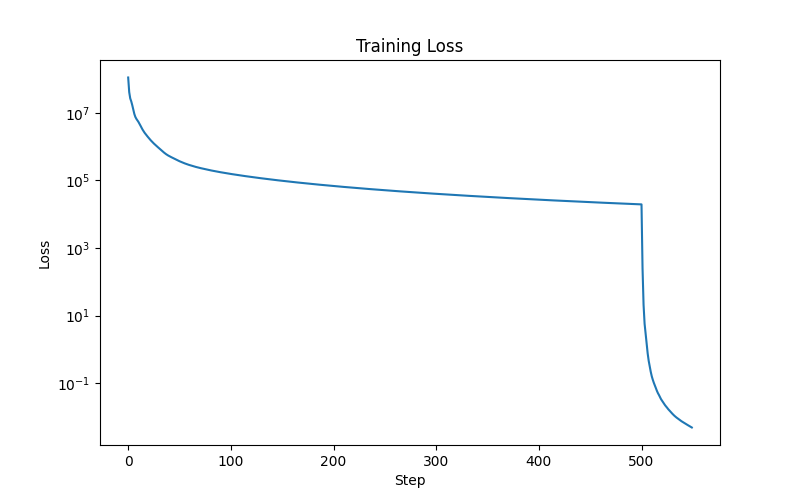

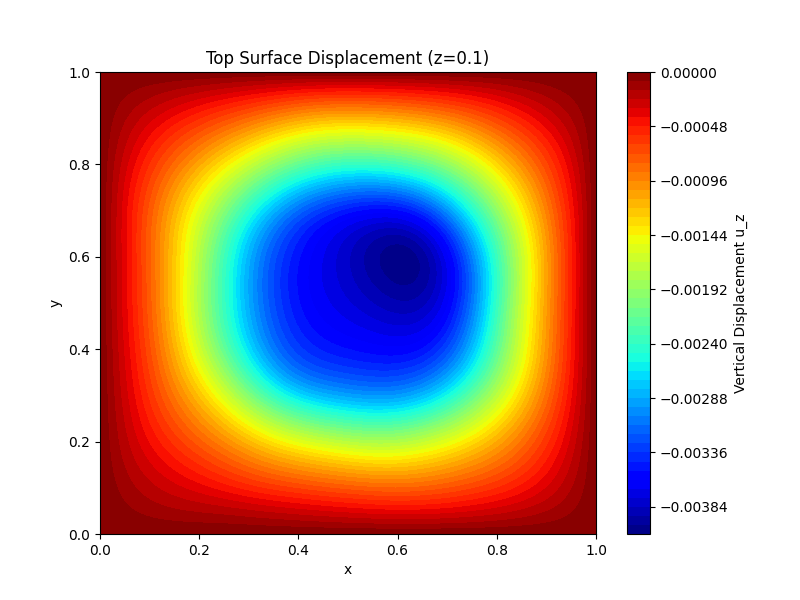

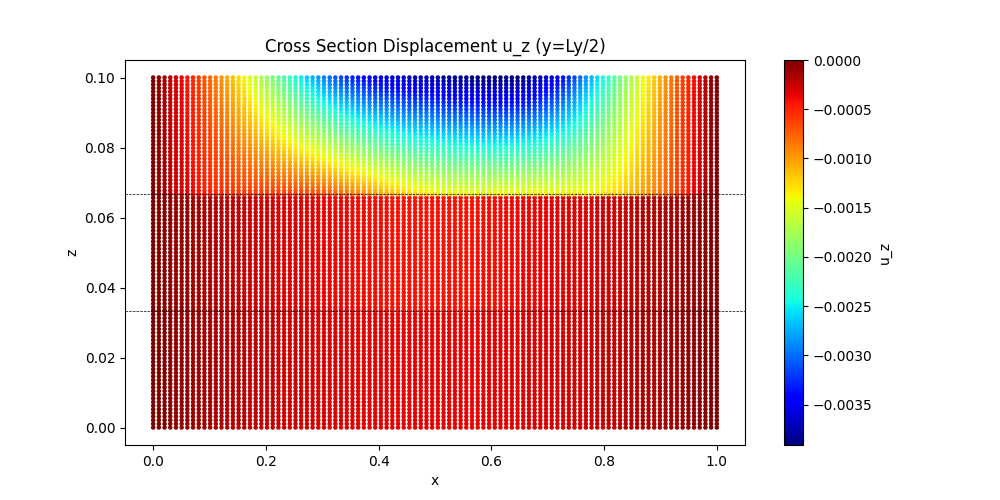

In [9]:
from IPython.display import Image, display

display(Image("loss_curve.png"))
display(Image("displacement_top.png"))
display(Image("cross_section.png"))


In [ ]:
%cd

In [10]:
compare_dir = repo_root 
sys.path.insert(0, str(compare_dir))
os.chdir(compare_dir)


In [4]:
%cd /content/Basic-PiNN-Model-For-Three-Layered-Collision

[Errno 2] No such file or directory: '/content/Basic-PiNN-Model-For-Three-Layered-Collision'
/content


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
import os
#sys.path.append(os.path.join(os.path.dirname(__file__), 'pinn-workflow'))
import pinn_config as config
import model
from scipy.interpolate import RegularGridInterpolator

def compare():
    print("Loading FEA Solution...")
    data = np.load("fea_solution.npy", allow_pickle=True).item()
    X_fea = data['x'] # (nx, ny, nz)
    Y_fea = data['y']
    Z_fea = data['z']
    U_fea = data['u'] # (nx, ny, nz, 3)
    
    # Grid axes
    x_axis = X_fea[:, 0, 0]
    y_axis = Y_fea[0, :, 0]
    z_axis = Z_fea[0, 0, :]
    
    print(f"FEA Grid: {len(x_axis)}x{len(y_axis)}x{len(z_axis)}")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
    pinn = model.MultiLayerPINN().to(device)
    try:
        pinn.load_state_dict(torch.load("pinn_model.pth"))
    except FileNotFoundError:
        print("Model not found, cannot plot.")
        return
    pinn.eval()
    pts = np.stack([X_fea.ravel(), Y_fea.ravel(), Z_fea.ravel()], axis=1) # (N, 3)
    
    # We need to query layer-wise because PINN takes layer_idx
    # Layer interfaces: 0, 0.033, 0.066, 0.1
    # Z coordinate determines layer
    z_flat = pts[:, 2]
    
    # Masks
    eps = 1e-5
    mask1 = (z_flat >= config.Layer_Interfaces[0] - eps) & (z_flat <= config.Layer_Interfaces[1] + eps)
    mask2 = (z_flat >= config.Layer_Interfaces[1] - eps) & (z_flat <= config.Layer_Interfaces[2] + eps)
    mask3 = (z_flat >= config.Layer_Interfaces[2] - eps) & (z_flat <= config.Layer_Interfaces[3] + eps)
    
    # Prioritize higher layers for overlaps (standard practice or arbitrary)
    # Actually, interfaces match, so just pick one.
    mask2 = mask2 & (~mask1) # simple exclusivity cleanup if needed, but overlap is fine if continuous
    # Better: strict intervals
    m1 = z_flat <= config.Layer_Interfaces[1]
    m2 = (z_flat > config.Layer_Interfaces[1]) & (z_flat <= config.Layer_Interfaces[2])
    m3 = z_flat > config.Layer_Interfaces[2]
    
    U_pinn_flat = np.zeros_like(pts)
    
    with torch.no_grad():
        # Layer 1
        p1 = torch.tensor(pts[m1], dtype=torch.float32).to(device)
        if len(p1) > 0:
            U_pinn_flat[m1] = pinn(p1, 0).cpu().numpy()
            
        # Layer 2
        p2 = torch.tensor(pts[m2], dtype=torch.float32).to(device)
        if len(p2) > 0:
            U_pinn_flat[m2] = pinn(p2, 1).cpu().numpy()
            
        # Layer 3
        p3 = torch.tensor(pts[m3], dtype=torch.float32).to(device)
        if len(p3) > 0:
            U_pinn_flat[m3] = pinn(p3, 2).cpu().numpy()
            
    U_pinn = U_pinn_flat.reshape(U_fea.shape)
    
    # 2. Compute Metrics
    # U_z at top surface
    u_z_fea_top = U_fea[:, :, -1, 2]
    u_z_pinn_top = U_pinn[:, :, -1, 2]
    
    abs_diff = np.abs(u_z_fea_top - u_z_pinn_top)
    mae = np.mean(abs_diff)
    max_err = np.max(abs_diff)
    denom = np.maximum(np.abs(u_z_fea_top), 1e-8)
    mape = np.mean(abs_diff / denom) * 100.0
    
    print(f"Comparison Results (Top Surface u_z):")
    print(f"MAE: {mae:.6f}")
    print(f"Max Error: {max_err:.6f}")
    print(f"Mean Abs Percent Error: {mape:.4f}%")
    print(f"Peak Deflection FEA: {u_z_fea_top.min():.6f}")
    print(f"Peak Deflection PINN: {u_z_pinn_top.min():.6f}")
    
    # 3. Plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Contours
    # FEA
    c1 = axes[0].contourf(X_fea[:,:,0], Y_fea[:,:,0], u_z_fea_top, levels=50, cmap='jet')
    axes[0].set_title("FEA Displacement u_z (Top)")
    plt.colorbar(c1, ax=axes[0])
    
    # PINN
    c2 = axes[1].contourf(X_fea[:,:,0], Y_fea[:,:,0], u_z_pinn_top, levels=50, cmap='jet')
    axes[1].set_title("PINN Displacement u_z (Top)")
    plt.colorbar(c2, ax=axes[1])
    
    # Error
    c3 = axes[2].contourf(X_fea[:,:,0], Y_fea[:,:,0], abs_diff, levels=50, cmap='magma')
    axes[2].set_title("Absolute Error |FEA - PINN|")
    plt.colorbar(c3, ax=axes[2])
    
    plt.savefig("comparison_top.png")
    print("Saved comparison_top.png")
    
    # Cross section
    # y index middle
    mid_y = U_fea.shape[1] // 2
    
    xz_X = X_fea[:, mid_y, :]
    xz_Z = Z_fea[:, mid_y, :]
    xz_Uz_fea = U_fea[:, mid_y, :, 2]
    xz_Uz_pinn = U_pinn[:, mid_y, :, 2]
    
    fig2, axes2 = plt.subplots(1, 2, figsize=(15, 6))
    
    c4 = axes2[0].contourf(xz_X, xz_Z, xz_Uz_fea, levels=50, cmap='jet')
    axes2[0].set_title("FEA Cross Section u_z")
    plt.colorbar(c4, ax=axes2[0])
    
    c5 = axes2[1].contourf(xz_X, xz_Z, xz_Uz_pinn, levels=50, cmap='jet')
    axes2[1].set_title("PINN Cross Section u_z")
    plt.colorbar(c5, ax=axes2[1])
    
    plt.savefig("comparison_cross_section.png")
    print("Saved comparison_cross_section.png")

if __name__ == "__main__":
    compare()

     